In [1]:
from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.cluster import MiniBatchKMeans
import mdtraj as md
from msmbuilder.hmm import VonMisesHMM

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

In [2]:
indir = './alanine_dipeptide'
topfile =  indir+'/ala2.pdb'
from glob import glob
traj_list = glob(indir+'/trajectory-*.dcd')

In [3]:
trajs = [md.load(traj_path, top=topfile) for traj_path in traj_list]

In [4]:
ftrajs = DihedralFeaturizer(sincos=False).fit_transform(trajs)

In [5]:
ftrajs[0].shape

(9999, 2)

In [6]:
hmm = VonMisesHMM(n_states=3)
hmm.fit(ftrajs)

In [7]:
hmm.means_

array([[-1.54921377, -0.1000479 ],
       [-1.41317236,  2.6196332 ],
       [-2.39927411,  2.73565793]], dtype=float32)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
def vm(x, k, mu):
    return np.exp(k*np.cos(x-mu))



[]

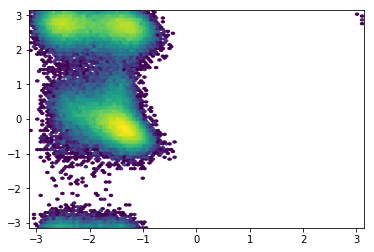

In [50]:
np.sqrt(fxx.shape[0])

316.22618487405498

In [126]:
cluster = MiniBatchKMeans(n_clusters=400)
ctrajs = cluster.fit_transform(ftrajs)

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


In [127]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [128]:
its = msm.timescales_msm(ctrajs, lags=np.arange(10), nits=10, n_jobs=-1)


15-12-17 13:49:58 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[8] WARNING  Ignored error during estimation: row, column, and data array must all be the same length


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


15-12-17 13:50:02 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[9] WARNING  Estimation has failed at lagtimes: [0]. Run single-lag estimation at these lags to track down the error.
15-12-17 13:50:02 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[9] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


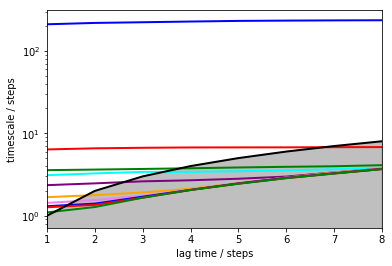

In [129]:
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)


In [130]:
msm_lag = 5
M = msm.estimate_markov_model(ctrajs, msm_lag)
len(M.active_set)

400

In [131]:
n_sets = 3
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership = M.metastable_memberships 
membership.shape

(400, 3)

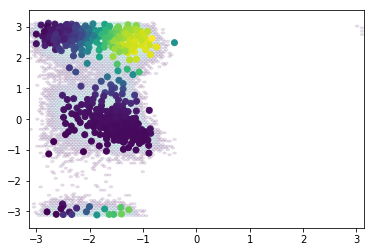

In [132]:
fxx = np.concatenate(ftrajs)
plt.hexbin(fxx[:,0], fxx[:, 1], bins='log', mincnt=1, alpha=0.1)
plt.scatter(cluster.cluster_centers_[:,0],cluster.cluster_centers_[:,1],c=membership[:,0])

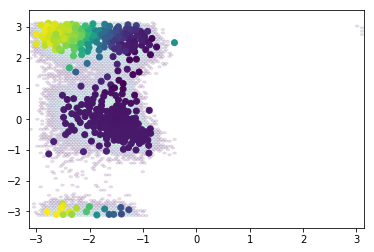

In [133]:
plt.hexbin(fxx[:,0], fxx[:, 1], bins='log', mincnt=1, alpha=0.1)
plt.scatter(cluster.cluster_centers_[:,0],cluster.cluster_centers_[:,1],c=membership[:,1])

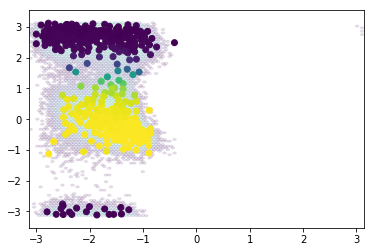

In [134]:
plt.hexbin(fxx[:,0], fxx[:, 1], bins='log', mincnt=1, alpha=0.1)
plt.scatter(cluster.cluster_centers_[:,0],cluster.cluster_centers_[:,1],c=membership[:,2])

In [135]:
membership[:5,:]

array([[ 0.93502165,  0.05350772,  0.01147063],
       [ 0.0378947 ,  0.06156738,  0.90053792],
       [ 0.18607579,  0.79932183,  0.01460238],
       [ 0.27651456,  0.7040568 ,  0.01942864],
       [ 0.83397903,  0.15090638,  0.01511459]])

In [136]:
_ = [print(dtraj.shape) for dtraj in ctrajs]

(9999,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [137]:
_ = [print(dtraj.shape) for dtraj in M.discrete_trajectories_full]

(9999,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [170]:
mem_trajs =  [[membership[:,i][dtraj][:, np.newaxis] for dtraj in M.discrete_trajectories_full] for i in range(n_sets)]

3

In [167]:
np.concatenate([mem_trajs[0][0], mem_trajs[1][0]], axis=1)

array([[ 0.10986639,  0.8864799 ],
       [ 0.22210277,  0.77299311],
       [ 0.08736319,  0.90582925],
       ..., 
       [ 0.84203156,  0.14841521],
       [ 0.85215164,  0.14108102],
       [ 0.86290973,  0.12799855]])

In [ ]:
traj_1 = [mem_trajs[0][0], mem_trajs[0][1], mem_trajs[0][2]]

In [173]:
all_trajs = []
for i in range(10):
    print('traj ', i)
    all_trajs.append(np.concatenate([mem_trajs[j][i] for j in range(n_sets)], axis=1))


traj  0
traj  1
traj  2
traj  3
traj  4
traj  5
traj  6
traj  7
traj  8
traj  9


In [175]:
all_trajs[0][:5,:]

array([[ 0.10986639,  0.8864799 ,  0.00365371],
       [ 0.22210277,  0.77299311,  0.00490412],
       [ 0.08736319,  0.90582925,  0.00680756],
       [ 0.34859128,  0.63800718,  0.01340155],
       [ 0.22210277,  0.77299311,  0.00490412]])

In [176]:
ctrajs[0][:5]

array([227, 289, 293, 235, 289], dtype=int32)

In [177]:
membership[[227, 289, 293, 235, 289], :]

array([[ 0.10986639,  0.8864799 ,  0.00365371],
       [ 0.22210277,  0.77299311,  0.00490412],
       [ 0.08736319,  0.90582925,  0.00680756],
       [ 0.34859128,  0.63800718,  0.01340155],
       [ 0.22210277,  0.77299311,  0.00490412]])

In [178]:
_ = [np.save('hmm_trajectories/traj-{}.npy'.format(i), traj) for i, traj in enumerate(all_trajs)]